
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [11]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [36]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
-------------------------------------------------------------------------------
Episode: 0 Total reward: 15.0 Average reward fake: 0.47195014357566833 Average reward real: 0.4863973557949066 Training q_loss: 22924691456.0000 Training g_loss: 0.7548 Training d_loss: 1.5158 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 15.0 Average reward fake: 0.4497385323047638 Average reward real: 0.525901734828949 Training q_loss: 79601434624.0000 Training g_loss: 0.8137 Training d_loss: 1.3983 Explore P: 0.9970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 33.0 Average reward fake: 0.3744269907474518 Average reward real: 0.606569766998291 Traini

-------------------------------------------------------------------------------
Episode: 22 Total reward: 18.0 Average reward fake: 0.5197471380233765 Average reward real: 0.5302529335021973 Training q_loss: 15390076928.0000 Training g_loss: 0.6612 Training d_loss: 1.4239 Explore P: 0.9479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 23 Total reward: 20.0 Average reward fake: 0.5406776070594788 Average reward real: 0.5079220533370972 Training q_loss: 52674535424.0000 Training g_loss: 0.6163 Training d_loss: 1.4978 Explore P: 0.9460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 31.0 Average reward fake: 0.48335158824920654 Average reward real: 0.48725563287734985 Training q_loss: 22238486528.0000 Training g_loss: 0.7318 Trainin

-------------------------------------------------------------------------------
Episode: 45 Total reward: 16.0 Average reward fake: 0.4586848318576813 Average reward real: 0.5228991508483887 Training q_loss: 49387585536.0000 Training g_loss: 0.7797 Training d_loss: 1.2912 Explore P: 0.9027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 46 Total reward: 17.0 Average reward fake: 0.4300403594970703 Average reward real: 0.4915597438812256 Training q_loss: 17042326528.0000 Training g_loss: 0.8440 Training d_loss: 1.3224 Explore P: 0.9012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 16.0 Average reward fake: 0.47621867060661316 Average reward real: 0.537950336933136 Training q_loss: 50656514048.0000 Training g_loss: 0.7459 Training 

-------------------------------------------------------------------------------
Episode: 68 Total reward: 13.0 Average reward fake: 0.48401862382888794 Average reward real: 0.46594923734664917 Training q_loss: 12131201024.0000 Training g_loss: 0.7450 Training d_loss: 1.4842 Explore P: 0.8584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 24.0 Average reward fake: 0.4417356848716736 Average reward real: 0.49392130970954895 Training q_loss: 14364749824.0000 Training g_loss: 0.8165 Training d_loss: 1.3005 Explore P: 0.8564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 23.0 Average reward fake: 0.43539535999298096 Average reward real: 0.5579009056091309 Training q_loss: 21609826304.0000 Training g_loss: 0.8348 Train

-------------------------------------------------------------------------------
Episode: 91 Total reward: 42.0 Average reward fake: 0.4357139468193054 Average reward real: 0.5130253434181213 Training q_loss: 42851352576.0000 Training g_loss: 0.8319 Training d_loss: 1.2768 Explore P: 0.8093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 34.0 Average reward fake: 0.44975823163986206 Average reward real: 0.5690886974334717 Training q_loss: 49900908544.0000 Training g_loss: 0.8029 Training d_loss: 1.1890 Explore P: 0.8066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 17.0 Average reward fake: 0.4354036748409271 Average reward real: 0.5287990570068359 Training q_loss: 97244487680.0000 Training g_loss: 0.8354 Training

-------------------------------------------------------------------------------
Episode: 114 Total reward: 29.0 Average reward fake: 0.6785861253738403 Average reward real: 0.37401121854782104 Training q_loss: 121499885568.0000 Training g_loss: 0.3877 Training d_loss: 2.1915 Explore P: 0.7662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 115 Total reward: 25.0 Average reward fake: 0.23564475774765015 Average reward real: 0.7393978834152222 Training q_loss: 21943193600.0000 Training g_loss: 1.4503 Training d_loss: 0.6853 Explore P: 0.7643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 16.0 Average reward fake: 0.2769850194454193 Average reward real: 0.71006178855896 Training q_loss: 24223969280.0000 Training g_loss: 1.2841 Train

-------------------------------------------------------------------------------
Episode: 136 Total reward: 20.0 Average reward fake: 0.4349232614040375 Average reward real: 0.5493021607398987 Training q_loss: 20437903360.0000 Training g_loss: 0.8330 Training d_loss: 1.2286 Explore P: 0.7034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 137 Total reward: 14.0 Average reward fake: 0.48219239711761475 Average reward real: 0.5037925243377686 Training q_loss: 51036344320.0000 Training g_loss: 0.7402 Training d_loss: 1.4330 Explore P: 0.7024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 138 Total reward: 31.0 Average reward fake: 0.5436455607414246 Average reward real: 0.43478110432624817 Training q_loss: 21421037568.0000 Training g_loss: 0.6317 Trai

-------------------------------------------------------------------------------
Episode: 159 Total reward: 18.0 Average reward fake: 0.48841315507888794 Average reward real: 0.5342339873313904 Training q_loss: 27298443264.0000 Training g_loss: 0.7166 Training d_loss: 1.3511 Explore P: 0.6457
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 160 Total reward: 19.0 Average reward fake: 0.49930667877197266 Average reward real: 0.49904507398605347 Training q_loss: 11223865344.0000 Training g_loss: 0.6945 Training d_loss: 1.4268 Explore P: 0.6445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 161 Total reward: 42.0 Average reward fake: 0.5504245162010193 Average reward real: 0.4564286768436432 Training q_loss: 10295683072.0000 Training g_loss: 0.5974 Tra

-------------------------------------------------------------------------------
Episode: 181 Total reward: 36.0 Average reward fake: 0.49580591917037964 Average reward real: 0.49359720945358276 Training q_loss: 21247074304.0000 Training g_loss: 0.7047 Training d_loss: 1.4402 Explore P: 0.5863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 77.0 Average reward fake: 0.45556747913360596 Average reward real: 0.5445528626441956 Training q_loss: 19054014464.0000 Training g_loss: 0.7915 Training d_loss: 1.2437 Explore P: 0.5819
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 46.0 Average reward fake: 0.4892995357513428 Average reward real: 0.49568867683410645 Training q_loss: 13506939904.0000 Training g_loss: 0.7226 Tr

-------------------------------------------------------------------------------
Episode: 204 Total reward: 39.0 Average reward fake: 0.4331150949001312 Average reward real: 0.5349792242050171 Training q_loss: 12403072000.0000 Training g_loss: 0.8536 Training d_loss: 1.2399 Explore P: 0.5139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 184.0 Average reward fake: 0.5530017614364624 Average reward real: 0.4420740604400635 Training q_loss: 10208370688.0000 Training g_loss: 0.5930 Training d_loss: 1.6449 Explore P: 0.5047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 20.0 Average reward fake: 0.5053322911262512 Average reward real: 0.47951194643974304 Training q_loss: 5646738432.0000 Training g_loss: 0.6846 Train

-------------------------------------------------------------------------------
Episode: 227 Total reward: 182.0 Average reward fake: 0.4620670974254608 Average reward real: 0.545691728591919 Training q_loss: 16152645632.0000 Training g_loss: 0.7766 Training d_loss: 1.2622 Explore P: 0.4183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 228 Total reward: 131.0 Average reward fake: 0.48134827613830566 Average reward real: 0.5449178814888 Training q_loss: 6748126720.0000 Training g_loss: 0.7426 Training d_loss: 1.3010 Explore P: 0.4129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 229 Total reward: 128.0 Average reward fake: 0.4687003791332245 Average reward real: 0.5360162258148193 Training q_loss: 15786928128.0000 Training g_loss: 0.7589 Trainin

-------------------------------------------------------------------------------
Episode: 249 Total reward: 84.0 Average reward fake: 0.23128312826156616 Average reward real: 0.796475350856781 Training q_loss: 15479933952.0000 Training g_loss: 5.6629 Training d_loss: 0.6637 Explore P: 0.3130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 250 Total reward: 140.0 Average reward fake: 0.2317175269126892 Average reward real: 0.7409371733665466 Training q_loss: 6097875968.0000 Training g_loss: 5.1722 Training d_loss: 0.7345 Explore P: 0.3088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 251 Total reward: 173.0 Average reward fake: 0.2603461742401123 Average reward real: 0.7937252521514893 Training q_loss: 19623104512.0000 Training g_loss: 8.0573 Train

-------------------------------------------------------------------------------
Episode: 271 Total reward: 129.0 Average reward fake: 0.35341864824295044 Average reward real: 0.6699952483177185 Training q_loss: 8849435648.0000 Training g_loss: 1.0404 Training d_loss: 0.8791 Explore P: 0.2309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 272 Total reward: 135.0 Average reward fake: 0.5361279249191284 Average reward real: 0.40752822160720825 Training q_loss: 7017629696.0000 Training g_loss: 0.6230 Training d_loss: 1.8059 Explore P: 0.2280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 141.0 Average reward fake: 0.6627995371818542 Average reward real: 0.3739848732948303 Training q_loss: 2691692544.0000 Training g_loss: 0.4151 Trai

-------------------------------------------------------------------------------
Episode: 294 Total reward: 90.0 Average reward fake: 0.46115973591804504 Average reward real: 0.5130623579025269 Training q_loss: 5240973312.0000 Training g_loss: 0.7811 Training d_loss: 1.3060 Explore P: 0.1787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 153.0 Average reward fake: 0.47651275992393494 Average reward real: 0.5082437992095947 Training q_loss: 8327256064.0000 Training g_loss: 0.7519 Training d_loss: 1.3706 Explore P: 0.1762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 296 Total reward: 156.0 Average reward fake: 0.4032630920410156 Average reward real: 0.5247370600700378 Training q_loss: 12339547136.0000 Training g_loss: 0.9077 Trai

-------------------------------------------------------------------------------
Episode: 316 Total reward: 170.0 Average reward fake: 0.4223691523075104 Average reward real: 0.5712512135505676 Training q_loss: 36469116928.0000 Training g_loss: 0.8739 Training d_loss: 1.1531 Explore P: 0.1300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 317 Total reward: 153.0 Average reward fake: 0.46939894556999207 Average reward real: 0.5204246044158936 Training q_loss: 16579059712.0000 Training g_loss: 0.7635 Training d_loss: 1.3504 Explore P: 0.1282
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 318 Total reward: 185.0 Average reward fake: 0.46846190094947815 Average reward real: 0.5235921740531921 Training q_loss: 3901321472.0000 Training g_loss: 0.7871 Tr

-------------------------------------------------------------------------------
Episode: 338 Total reward: 199.0 Average reward fake: 0.4656400978565216 Average reward real: 0.49260061979293823 Training q_loss: 38115069952.0000 Training g_loss: 0.7646 Training d_loss: 1.3918 Explore P: 0.0885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 339 Total reward: 199.0 Average reward fake: 0.36389878392219543 Average reward real: 0.6250108480453491 Training q_loss: 17046499328.0000 Training g_loss: 1.0129 Training d_loss: 0.9647 Explore P: 0.0870
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 340 Total reward: 199.0 Average reward fake: 0.40082690119743347 Average reward real: 0.5590373873710632 Training q_loss: 2145763456.0000 Training g_loss: 0.9398 T

-------------------------------------------------------------------------------
Episode: 360 Total reward: 199.0 Average reward fake: 0.4097664952278137 Average reward real: 0.5992327332496643 Training q_loss: 1662163456.0000 Training g_loss: 0.8922 Training d_loss: 1.1044 Explore P: 0.0620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 361 Total reward: 51.0 Average reward fake: 0.40102308988571167 Average reward real: 0.5642013549804688 Training q_loss: 1726179840.0000 Training g_loss: 0.9148 Training d_loss: 1.1497 Explore P: 0.0618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 95.0 Average reward fake: 0.46931716799736023 Average reward real: 0.37785330414772034 Training q_loss: 988066944.0000 Training g_loss: 0.7577 Traini

-------------------------------------------------------------------------------
Episode: 383 Total reward: 49.0 Average reward fake: 0.5249303579330444 Average reward real: 0.4399527311325073 Training q_loss: 13300722688.0000 Training g_loss: 0.6476 Training d_loss: 1.7514 Explore P: 0.0524
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 199.0 Average reward fake: 0.3206804394721985 Average reward real: 0.6497280597686768 Training q_loss: 8844357632.0000 Training g_loss: 1.1356 Training d_loss: 0.8568 Explore P: 0.0515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 385 Total reward: 199.0 Average reward fake: 0.4333362877368927 Average reward real: 0.5414833426475525 Training q_loss: 4958522368.0000 Training g_loss: 0.8388 Traini

-------------------------------------------------------------------------------
Episode: 406 Total reward: 11.0 Average reward fake: 0.32945629954338074 Average reward real: 0.5445102453231812 Training q_loss: 2087487799296.0000 Training g_loss: 1.1103 Training d_loss: 1.2134 Explore P: 0.0455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 407 Total reward: 9.0 Average reward fake: 0.3032088279724121 Average reward real: 0.7016893625259399 Training q_loss: 1161513533440.0000 Training g_loss: 1.1933 Training d_loss: 0.9244 Explore P: 0.0455
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 11.0 Average reward fake: 0.25008919835090637 Average reward real: 0.7908596992492676 Training q_loss: 2902044180480.0000 Training g_loss: 1.3859

-------------------------------------------------------------------------------
Episode: 428 Total reward: 43.0 Average reward fake: 0.39020782709121704 Average reward real: 0.6348508596420288 Training q_loss: 57007075328.0000 Training g_loss: 0.9595 Training d_loss: 1.1633 Explore P: 0.0438
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 47.0 Average reward fake: 0.6037609577178955 Average reward real: 0.43841874599456787 Training q_loss: 840568995840.0000 Training g_loss: 0.5053 Training d_loss: 1.7783 Explore P: 0.0437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 430 Total reward: 47.0 Average reward fake: 0.5446150898933411 Average reward real: 0.4895915687084198 Training q_loss: 209432690688.0000 Training g_loss: 0.6078 Tr

-------------------------------------------------------------------------------
Episode: 450 Total reward: 103.0 Average reward fake: 0.05770741403102875 Average reward real: 0.8851955533027649 Training q_loss: 1433784287232.0000 Training g_loss: 5.3237 Training d_loss: 0.2212 Explore P: 0.0401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 96.0 Average reward fake: 0.12135307490825653 Average reward real: 0.9113417267799377 Training q_loss: 605897883648.0000 Training g_loss: 9.4697 Training d_loss: 0.3092 Explore P: 0.0398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 94.0 Average reward fake: 0.09881962090730667 Average reward real: 0.8849300146102905 Training q_loss: 434553454592.0000 Training g_loss: 6.771

-------------------------------------------------------------------------------
Episode: 472 Total reward: 199.0 Average reward fake: 0.5676590204238892 Average reward real: 0.4531262218952179 Training q_loss: 25161865216.0000 Training g_loss: 0.5666 Training d_loss: 1.6523 Explore P: 0.0305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 473 Total reward: 199.0 Average reward fake: 0.42477715015411377 Average reward real: 0.5698533058166504 Training q_loss: 6937917440.0000 Training g_loss: 0.8563 Training d_loss: 1.1272 Explore P: 0.0301
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 199.0 Average reward fake: 0.3955439329147339 Average reward real: 0.6867735385894775 Training q_loss: 14662929408.0000 Training g_loss: 0.9380 Tra

-------------------------------------------------------------------------------
Episode: 494 Total reward: 163.0 Average reward fake: 0.4936334192752838 Average reward real: 0.5328879356384277 Training q_loss: 403813302272.0000 Training g_loss: 0.7061 Training d_loss: 1.3154 Explore P: 0.0266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 495 Total reward: 196.0 Average reward fake: 0.4736534059047699 Average reward real: 0.5181887745857239 Training q_loss: 32292132864.0000 Training g_loss: 0.7474 Training d_loss: 1.3027 Explore P: 0.0263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 199.0 Average reward fake: 0.4746669828891754 Average reward real: 0.48113682866096497 Training q_loss: 23775596544.0000 Training g_loss: 0.7453 T

-------------------------------------------------------------------------------
Episode: 516 Total reward: 147.0 Average reward fake: 0.45093536376953125 Average reward real: 0.5545732975006104 Training q_loss: 40876290048.0000 Training g_loss: 0.7966 Training d_loss: 1.2163 Explore P: 0.0216
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 517 Total reward: 149.0 Average reward fake: 0.533189594745636 Average reward real: 0.4360136389732361 Training q_loss: 39419461632.0000 Training g_loss: 0.6302 Training d_loss: 1.6310 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 518 Total reward: 180.0 Average reward fake: 0.46536338329315186 Average reward real: 0.5422413349151611 Training q_loss: 26518695936.0000 Training g_loss: 0.8174 Tr

-------------------------------------------------------------------------------
Episode: 538 Total reward: 157.0 Average reward fake: 0.5421876311302185 Average reward real: 0.5197083353996277 Training q_loss: 831439241216.0000 Training g_loss: 0.6136 Training d_loss: 1.4514 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 539 Total reward: 167.0 Average reward fake: 0.452901691198349 Average reward real: 0.5271959900856018 Training q_loss: 26930857984.0000 Training g_loss: 0.8244 Training d_loss: 1.3893 Explore P: 0.0183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 199.0 Average reward fake: 0.5138683319091797 Average reward real: 0.44742730259895325 Training q_loss: 33642387456.0000 Training g_loss: 0.6682 Tr

-------------------------------------------------------------------------------
Episode: 560 Total reward: 199.0 Average reward fake: 0.4253723621368408 Average reward real: 0.5736039876937866 Training q_loss: 14617927680.0000 Training g_loss: 0.8587 Training d_loss: 1.1288 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 561 Total reward: 199.0 Average reward fake: 0.47598662972450256 Average reward real: 0.5389308929443359 Training q_loss: 10581231616.0000 Training g_loss: 0.7426 Training d_loss: 1.2701 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 562 Total reward: 125.0 Average reward fake: 0.49221688508987427 Average reward real: 0.5108156204223633 Training q_loss: 42728194048.0000 Training g_loss: 0.7097 T

-------------------------------------------------------------------------------
Episode: 582 Total reward: 81.0 Average reward fake: 0.4576306939125061 Average reward real: 0.5227992534637451 Training q_loss: 14523478016.0000 Training g_loss: 0.7824 Training d_loss: 1.2768 Explore P: 0.0147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 199.0 Average reward fake: 0.46759650111198425 Average reward real: 0.5195505619049072 Training q_loss: 11899965440.0000 Training g_loss: 0.7739 Training d_loss: 1.3028 Explore P: 0.0146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 199.0 Average reward fake: 0.5122500061988831 Average reward real: 0.5659606456756592 Training q_loss: 5575777280.0000 Training g_loss: 0.6972 Trai

-------------------------------------------------------------------------------
Episode: 604 Total reward: 35.0 Average reward fake: 0.49465999007225037 Average reward real: 0.5095430612564087 Training q_loss: 48185704448.0000 Training g_loss: 0.7050 Training d_loss: 1.5266 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 605 Total reward: 11.0 Average reward fake: 0.5365109443664551 Average reward real: 0.44586312770843506 Training q_loss: 92654370816.0000 Training g_loss: 0.6261 Training d_loss: 1.8276 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 606 Total reward: 11.0 Average reward fake: 0.5186592936515808 Average reward real: 0.3708292841911316 Training q_loss: 112337117184.0000 Training g_loss: 0.6575 Tra

-------------------------------------------------------------------------------
Episode: 626 Total reward: 11.0 Average reward fake: 0.17838650941848755 Average reward real: 0.8211979866027832 Training q_loss: 2186444537856.0000 Training g_loss: 1.7407 Training d_loss: 0.4241 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 9.0 Average reward fake: 0.24512282013893127 Average reward real: 0.6954955458641052 Training q_loss: 12315238858752.0000 Training g_loss: 1.4129 Training d_loss: 0.7116 Explore P: 0.0132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 628 Total reward: 9.0 Average reward fake: 0.41105160117149353 Average reward real: 0.5855973958969116 Training q_loss: 16112522625024.0000 Training g_loss: 0.88

-------------------------------------------------------------------------------
Episode: 649 Total reward: 11.0 Average reward fake: 0.40353402495384216 Average reward real: 0.6069808602333069 Training q_loss: 41048319459328.0000 Training g_loss: 0.9075 Training d_loss: 1.1414 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 10.0 Average reward fake: 0.40694984793663025 Average reward real: 0.5030906200408936 Training q_loss: 168291549052928.0000 Training g_loss: 0.8991 Training d_loss: 1.4181 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 651 Total reward: 7.0 Average reward fake: 0.46305128931999207 Average reward real: 0.41085365414619446 Training q_loss: 30539467718656.0000 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 672 Total reward: 8.0 Average reward fake: 0.4278146028518677 Average reward real: 0.48890015482902527 Training q_loss: 10821366185984.0000 Training g_loss: 0.8491 Training d_loss: 1.4021 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 673 Total reward: 8.0 Average reward fake: 0.4828230142593384 Average reward real: 0.4976920783519745 Training q_loss: 50821001641984.0000 Training g_loss: 0.7281 Training d_loss: 1.5308 Explore P: 0.0131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 9.0 Average reward fake: 0.5409098267555237 Average reward real: 0.4740830361843109 Training q_loss: 11114598367232.0000 Training g_loss: 0.6145

-------------------------------------------------------------------------------
Episode: 694 Total reward: 9.0 Average reward fake: 0.4313744008541107 Average reward real: 0.4928083121776581 Training q_loss: 345788454535168.0000 Training g_loss: 0.8408 Training d_loss: 1.3552 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 12.0 Average reward fake: 0.42506295442581177 Average reward real: 0.5187950730323792 Training q_loss: 246627507896320.0000 Training g_loss: 0.8556 Training d_loss: 1.2627 Explore P: 0.0130
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 696 Total reward: 9.0 Average reward fake: 0.482694536447525 Average reward real: 0.5725008249282837 Training q_loss: 41402138361856.0000 Training g_loss: 0.72

-------------------------------------------------------------------------------
Episode: 716 Total reward: 147.0 Average reward fake: 0.4960988759994507 Average reward real: 0.5234302282333374 Training q_loss: 203049276538880.0000 Training g_loss: 0.7010 Training d_loss: 1.3834 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 199.0 Average reward fake: 0.49935001134872437 Average reward real: 0.5077774524688721 Training q_loss: 1385899622400.0000 Training g_loss: 0.6945 Training d_loss: 1.3827 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 718 Total reward: 117.0 Average reward fake: 0.48577266931533813 Average reward real: 0.49805042147636414 Training q_loss: 84737683095552.0000 Training g_loss

-------------------------------------------------------------------------------
Episode: 738 Total reward: 55.0 Average reward fake: 0.4211373031139374 Average reward real: 0.5114625096321106 Training q_loss: 76059525513216.0000 Training g_loss: 0.8668 Training d_loss: 1.2553 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 56.0 Average reward fake: 0.5427706241607666 Average reward real: 0.4373440146446228 Training q_loss: 32951037329408.0000 Training g_loss: 0.6160 Training d_loss: 1.7435 Explore P: 0.0125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 69.0 Average reward fake: 0.4814962148666382 Average reward real: 0.5363637804985046 Training q_loss: 766339186688.0000 Training g_loss: 0.7336

-------------------------------------------------------------------------------
Episode: 760 Total reward: 133.0 Average reward fake: 0.45394501090049744 Average reward real: 0.5831146836280823 Training q_loss: 20342567337984.0000 Training g_loss: 0.7928 Training d_loss: 1.1622 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 135.0 Average reward fake: 0.4705316424369812 Average reward real: 0.5358684062957764 Training q_loss: 11344605609984.0000 Training g_loss: 0.7745 Training d_loss: 1.3248 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 124.0 Average reward fake: 0.4109758734703064 Average reward real: 0.5114923715591431 Training q_loss: 7929395675136.0000 Training g_loss: 0

-------------------------------------------------------------------------------
Episode: 782 Total reward: 199.0 Average reward fake: 0.48241057991981506 Average reward real: 0.34752801060676575 Training q_loss: 193320845312.0000 Training g_loss: 0.7291 Training d_loss: 1.7899 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 783 Total reward: 199.0 Average reward fake: 0.30856239795684814 Average reward real: 0.7473269701004028 Training q_loss: 196936351744.0000 Training g_loss: 1.3333 Training d_loss: 0.7369 Explore P: 0.0114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 199.0 Average reward fake: 0.4622998535633087 Average reward real: 0.5345494747161865 Training q_loss: 175234891776.0000 Training g_loss: 0.77

-------------------------------------------------------------------------------
Episode: 804 Total reward: 199.0 Average reward fake: 0.5151304602622986 Average reward real: 0.47165215015411377 Training q_loss: 39805870080.0000 Training g_loss: 0.6633 Training d_loss: 1.4951 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 805 Total reward: 199.0 Average reward fake: 0.579446017742157 Average reward real: 0.4471907317638397 Training q_loss: 91948924928.0000 Training g_loss: 0.5476 Training d_loss: 1.7090 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 806 Total reward: 199.0 Average reward fake: 0.5212954878807068 Average reward real: 0.49101993441581726 Training q_loss: 72926732288.0000 Training g_loss: 0.6651 Tr

-------------------------------------------------------------------------------
Episode: 826 Total reward: 199.0 Average reward fake: 0.5708827376365662 Average reward real: 0.4354429543018341 Training q_loss: 16171616256.0000 Training g_loss: 0.5621 Training d_loss: 1.8693 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 827 Total reward: 199.0 Average reward fake: 0.5878742933273315 Average reward real: 0.3610306978225708 Training q_loss: 8225313792.0000 Training g_loss: 0.5319 Training d_loss: 2.0709 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 828 Total reward: 199.0 Average reward fake: 0.4942987859249115 Average reward real: 0.5543929934501648 Training q_loss: 10679086080.0000 Training g_loss: 0.7212 Trai

-------------------------------------------------------------------------------
Episode: 849 Total reward: 71.0 Average reward fake: 0.4726404845714569 Average reward real: 0.5276522040367126 Training q_loss: 8634001408.0000 Training g_loss: 0.7496 Training d_loss: 1.2897 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 73.0 Average reward fake: 0.3884730637073517 Average reward real: 0.5698673129081726 Training q_loss: 21319671808.0000 Training g_loss: 1.1018 Training d_loss: 1.1431 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 75.0 Average reward fake: 0.40440651774406433 Average reward real: 0.5573655962944031 Training q_loss: 18189836288.0000 Training g_loss: 0.9085 Traini

-------------------------------------------------------------------------------
Episode: 872 Total reward: 76.0 Average reward fake: 0.34618622064590454 Average reward real: 0.5808822512626648 Training q_loss: 4559891456.0000 Training g_loss: 1.1166 Training d_loss: 1.0203 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 873 Total reward: 83.0 Average reward fake: 0.43779289722442627 Average reward real: 0.5943313837051392 Training q_loss: 25248149504.0000 Training g_loss: 0.8476 Training d_loss: 1.2073 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 874 Total reward: 73.0 Average reward fake: 0.6034221053123474 Average reward real: 0.4029141366481781 Training q_loss: 4531939328.0000 Training g_loss: 0.5116 Traini

-------------------------------------------------------------------------------
Episode: 895 Total reward: 73.0 Average reward fake: 0.4673348367214203 Average reward real: 0.5148686766624451 Training q_loss: 4469269504.0000 Training g_loss: 0.7649 Training d_loss: 1.3120 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 896 Total reward: 71.0 Average reward fake: 0.5195497274398804 Average reward real: 0.478623628616333 Training q_loss: 3634897920.0000 Training g_loss: 0.6603 Training d_loss: 1.4931 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 897 Total reward: 74.0 Average reward fake: 0.563016951084137 Average reward real: 0.48449042439460754 Training q_loss: 5786330112.0000 Training g_loss: 0.5757 Training d

-------------------------------------------------------------------------------
Episode: 918 Total reward: 199.0 Average reward fake: 0.5501676797866821 Average reward real: 0.444052129983902 Training q_loss: 4080912384.0000 Training g_loss: 0.6009 Training d_loss: 1.6194 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 919 Total reward: 199.0 Average reward fake: 0.5343239307403564 Average reward real: 0.4809858798980713 Training q_loss: 3156038656.0000 Training g_loss: 0.6280 Training d_loss: 1.5088 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 920 Total reward: 199.0 Average reward fake: 0.43849655985832214 Average reward real: 0.5267305970191956 Training q_loss: 2560895488.0000 Training g_loss: 0.8308 Traini

-------------------------------------------------------------------------------
Episode: 941 Total reward: 126.0 Average reward fake: 0.6039650440216064 Average reward real: 0.35868412256240845 Training q_loss: 2552114944.0000 Training g_loss: 0.5093 Training d_loss: 2.4051 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 942 Total reward: 114.0 Average reward fake: 0.5622103214263916 Average reward real: 0.4696945548057556 Training q_loss: 1080699264.0000 Training g_loss: 0.5819 Training d_loss: 1.7331 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 117.0 Average reward fake: 0.5145039558410645 Average reward real: 0.37667012214660645 Training q_loss: 7897964032.0000 Training g_loss: 0.6793 Trai

-------------------------------------------------------------------------------
Episode: 963 Total reward: 136.0 Average reward fake: 0.5298097133636475 Average reward real: 0.5108904242515564 Training q_loss: 1694052352.0000 Training g_loss: 0.6423 Training d_loss: 1.4413 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 150.0 Average reward fake: 0.531897246837616 Average reward real: 0.5377227067947388 Training q_loss: 6468789760.0000 Training g_loss: 0.6402 Training d_loss: 1.3920 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 965 Total reward: 137.0 Average reward fake: 0.4855876863002777 Average reward real: 0.5144650936126709 Training q_loss: 5582017536.0000 Training g_loss: 0.7213 Trainin

-------------------------------------------------------------------------------
Episode: 986 Total reward: 199.0 Average reward fake: 0.45776480436325073 Average reward real: 0.506533682346344 Training q_loss: 2262359552.0000 Training g_loss: 0.7813 Training d_loss: 1.3274 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 987 Total reward: 199.0 Average reward fake: 0.4667661786079407 Average reward real: 0.4777596592903137 Training q_loss: 5678661632.0000 Training g_loss: 0.7670 Training d_loss: 1.3821 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 988 Total reward: 199.0 Average reward fake: 0.489004522562027 Average reward real: 0.48947444558143616 Training q_loss: 1254215808.0000 Training g_loss: 0.7153 Traini

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

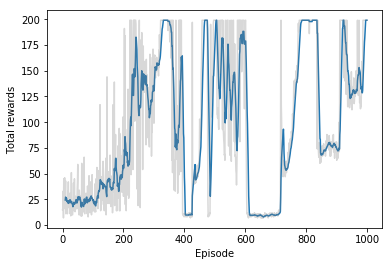

In [38]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

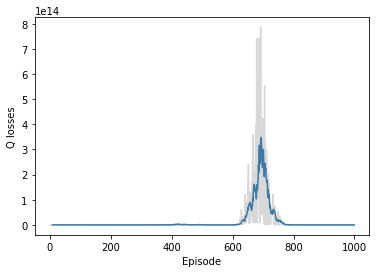

In [39]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

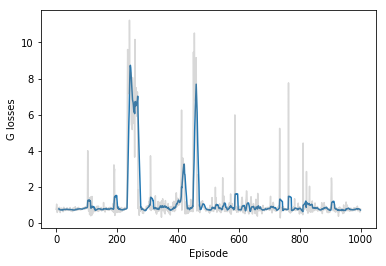

In [40]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

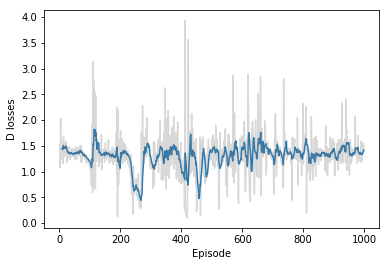

In [41]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [44]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/DQA


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


NotFoundError: Key beta1_power_1 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]
	 [[Node: save_2/RestoreV2/_193 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_198_save_2/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-cbed6f5e39f8>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key beta1_power_1 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]
	 [[Node: save_2/RestoreV2/_193 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_198_save_2/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [43]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.